<a href="https://www.kaggle.com/code/shreyasdomde/weather-detection?scriptVersionId=165146840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, callbacks

import warnings
warnings.filterwarnings("ignore")

2024-03-02 15:21:31.573499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 15:21:31.573592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 15:21:31.683632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
datadir = '/kaggle/input/weather-dataset/dataset'

# 😶‍🌫️ Exploring the dataset

In [3]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

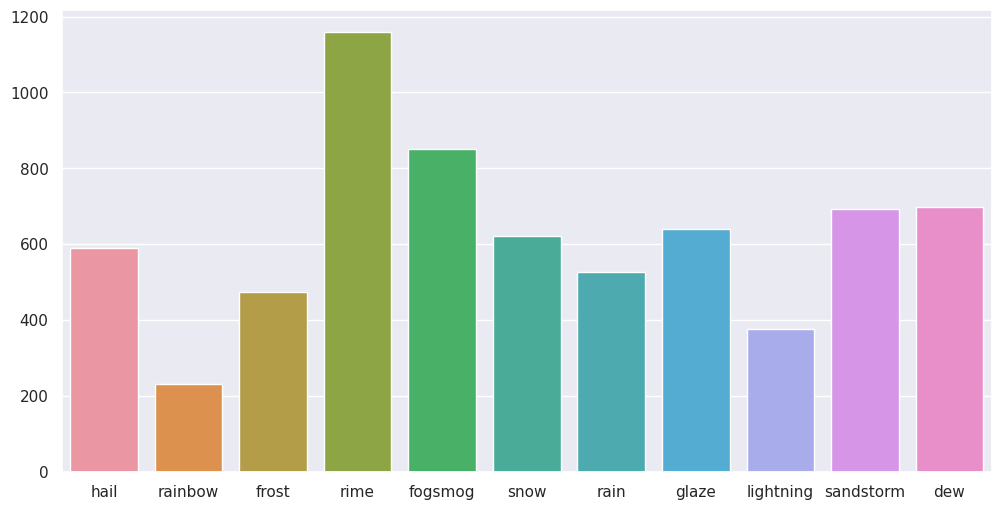

In [4]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

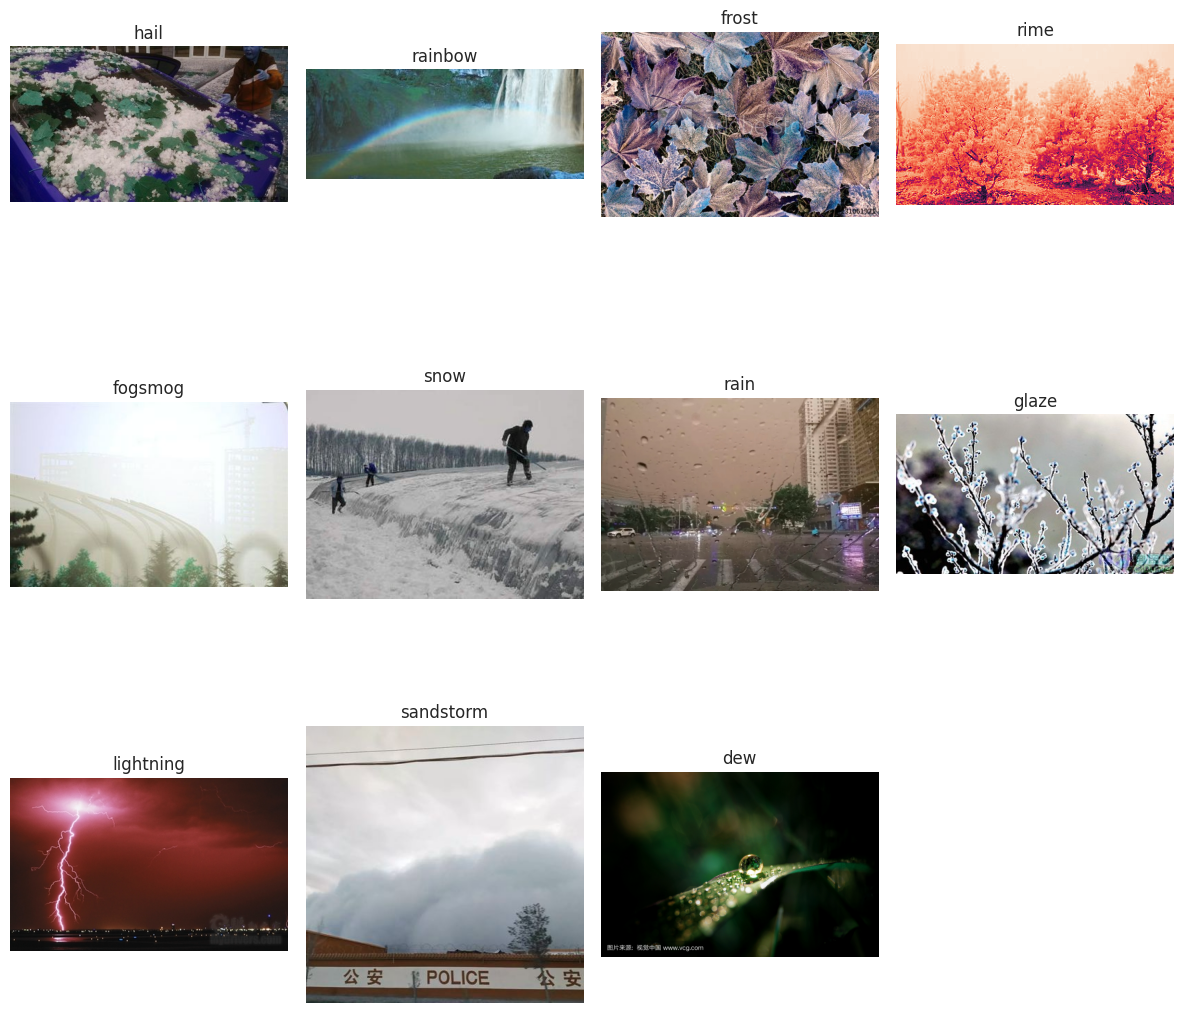

In [5]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
    
plt.tight_layout()
plt.show()

# ✂️ Splittinng dataset

In [6]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [7]:
df.head()

,filepaths,labels
0,/kaggle/input/weather-dataset/dataset/hail/010...,hail
1,/kaggle/input/weather-dataset/dataset/hail/037...,hail
2,/kaggle/input/weather-dataset/dataset/hail/028...,hail
3,/kaggle/input/weather-dataset/dataset/hail/007...,hail
4,/kaggle/input/weather-dataset/dataset/hail/007...,hail


# 🎋 Preprocessing Images

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=44)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype = 'float32',
    rescale=1/255.0,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    validation_split=0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype = 'float32',
    rescale=1/255.0,
)

In [10]:
input_size = (100, 100)

train_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size =input_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training'
)

val_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size =input_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation'
)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.


In [11]:
test_data = train_datagen.flow_from_dataframe(
    df_test, 
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = input_size,
    color_mode = 'rgb',
    batch_size = 64
)

Found 1373 validated image filenames belonging to 11 classes.


# 🪸 Training models

In [12]:
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=11, activation='softmax'),
])

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,701,067 (37.01 MB)

 Trainable params: 9,698,827 (37.00 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [15]:
EPOCHS = 100
early_stop = callbacks.EarlyStopping(
    patience=10,
    monitor='val_loss'
)

In [16]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = EPOCHS,
    batch_size = 64,
    callbacks = [early_stop]
)

Epoch 1/100


2024-03-02 15:22:02.104987: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.61992, expected 2.66164
2024-03-02 15:22:02.105041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.96151, expected 4.00323
2024-03-02 15:22:02.105050: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.22564, expected 5.26736
2024-03-02 15:22:02.105058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.0663, expected 5.10801
2024-03-02 15:22:02.105066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.91716, expected 6.95888
2024-03-02 15:22:02.105073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.98431, expected 6.02603
2024-03-02 15:22:02.105082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 8.08025, expected 7.12196
2024-03-02 15:22:02.105089: E external/local_xla/xla/ser

  1/138 ━━━━━━━━━━━━━━━━━━━━ 36:39 16s/step - accuracy: 0.0938 - loss: 3.0600

I0000 00:00:1709392928.674838      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 11/138 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.2129 - loss: 2.5080

2024-03-02 15:22:13.776861: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.81771, expected 2.27775
2024-03-02 15:22:13.776926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.22659, expected 3.68663
2024-03-02 15:22:13.776941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.01181, expected 3.47186
2024-03-02 15:22:13.776958: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.01981, expected 3.47985
2024-03-02 15:22:13.776971: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.38804, expected 3.84808
2024-03-02 15:22:13.776982: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 3.9098, expected 3.36984
2024-03-02 15:22:13.776993: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.106, expected 3.56604
2024-03-02 15:22:13.777003: E external/local_xla/xla/s

136/138 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.4229 - loss: 1.7934

2024-03-02 15:23:09.912406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.7132, expected 1.92063
2024-03-02 15:23:09.912466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.21648, expected 3.42391
2024-03-02 15:23:09.912480: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.17139, expected 4.37881
2024-03-02 15:23:09.912496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.17291, expected 4.38034
2024-03-02 15:23:09.912512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.7269, expected 4.93433
2024-03-02 15:23:09.912523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.48863, expected 5.69605
2024-03-02 15:23:09.912532: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.51953, expected 4.72696
2024-03-02 15:23:09.912542: E external/local_xla/xla/serv

138/138 ━━━━━━━━━━━━━━━━━━━━ 78s 452ms/step - accuracy: 0.4247 - loss: 1.7874 - val_accuracy: 0.1386 - val_loss: 4.6950
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.5979 - loss: 1.2155 - val_accuracy: 0.1987 - val_loss: 4.6686
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.6346 - loss: 1.0578 - val_accuracy: 0.4129 - val_loss: 2.1091
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.6395 - loss: 1.0751 - val_accuracy: 0.3974 - val_loss: 3.0776
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.6653 - loss: 1.0124 - val_accuracy: 0.6080 - val_loss: 1.2133
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.6727 - loss: 0.9466 - val_accuracy: 0.4731 - val_loss: 1.8272
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.6829 - loss: 0.9388 - val_accuracy: 0.6372 - val_loss: 1.1010
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.6891 - loss: 0.905

# Evaluating model

In [17]:
model.evaluate(test_data)

2024-03-02 15:37:36.353186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10000: 3.05616, expected 2.15837
2024-03-02 15:37:36.353229: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10001: 4.40112, expected 3.50333
2024-03-02 15:37:36.353238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10002: 5.00688, expected 4.1091
2024-03-02 15:37:36.353247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10003: 5.05187, expected 4.15408
2024-03-02 15:37:36.353254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10004: 5.95739, expected 5.0596
2024-03-02 15:37:36.353262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10005: 6.79288, expected 5.89509
2024-03-02 15:37:36.353270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10006: 6.19189, expected 5.2941
2024-03-02 15:37:36.353277: E 

21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7472 - loss: 0.8600

2024-03-02 15:37:50.516569: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10000: 1.91901, expected 1.54176
2024-03-02 15:37:50.516705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19999: 2.27443, expected 1.89719
2024-03-02 15:37:50.516797: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30000: 3.42859, expected 2.50394
2024-03-02 15:37:50.516812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30001: 5.12525, expected 4.2006
2024-03-02 15:37:50.516825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30002: 5.90711, expected 4.98246
2024-03-02 15:37:50.516838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30003: 5.68365, expected 4.759
2024-03-02 15:37:50.516852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30004: 6.4342, expected 5.50956
2024-03-02 15:37:50.516868: E e

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 652ms/step - accuracy: 0.7471 - loss: 0.8847


[1.1437420845031738, 0.7458121180534363]

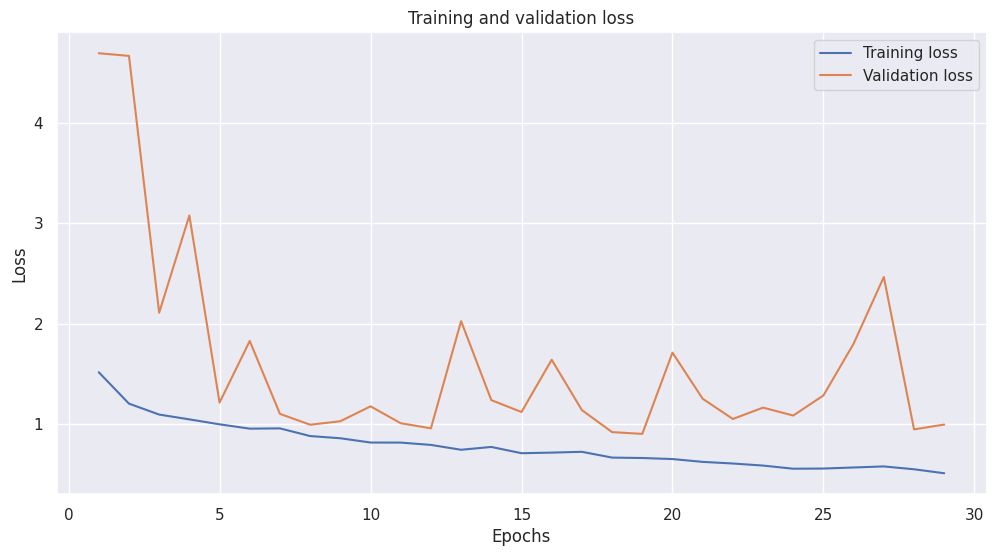

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

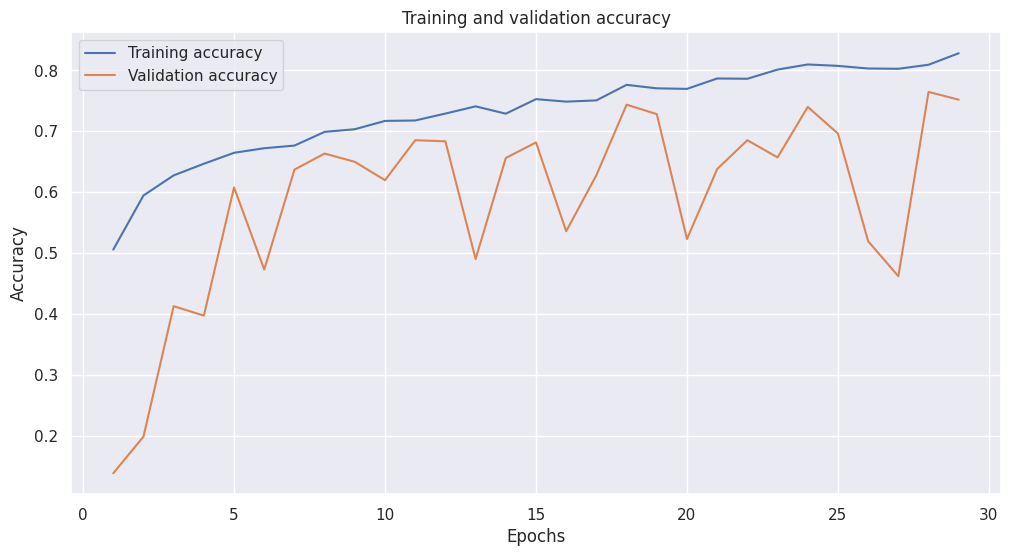

In [19]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()